In [1]:
import pickle
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from yellowbrick.classifier import ConfusionMatrix
from sklearn.model_selection import GridSearchCV

In [2]:
filePath = '../DataBases/VlEncodedBase.pkl'
with open(filePath, 'rb') as f:
    colunas, CD4_AttributesTraining, CD4_4AttributesTest, CD4_ClassResultsTraining, CD4_ClassResultsTest = pickle.load(f)

***GridSearch***

In [3]:
params = {
    'n_estimators': [100, 300, 500, 800],
    'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    'criterion': ['gini', 'entropy'],
    'max_features': ['auto', 'sqrt', 'log2', None],
    'min_weight_fraction_leaf': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5],
    'max_leaf_nodes': [None, 2, 5, 10, 20, 50, 100],
    'class_weight': [None, 'balanced'],
    'ccp_alpha': [0.0, 0.001, 0.01, 0.1, 1.0],
}

In [4]:
grid = GridSearchCV(
    RandomForestClassifier(),
    param_grid=params,
    cv=5,
    verbose=1,
    n_jobs=-1
)

In [5]:
grid.fit(CD4_AttributesTraining, CD4_ClassResultsTraining)

Fitting 5 folds for each of 87333120 candidates, totalling 436665600 fits


KeyboardInterrupt: 

In [6]:
print(grid.best_params_)
print(grid.best_score_)

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

***Criando a árvore***

In [10]:
arvore = tree.DecisionTreeClassifier(criterion= 'gini', max_depth= 2, max_features= None, splitter= 'best')

In [11]:
arvore.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=2)

***Plotando a árvore***

In [ ]:
plt.subplots(figsize=(10,10))
tree.plot_tree(arvore, feature_names=colunas, class_names=arvore.classes_, filled=True)
#plt.savefig('arvore.png')

***Prevendo***

In [13]:
previsoes = arvore.predict(x_test)

In [9]:
previsoes

array(['recurrence-events', 'recurrence-events', 'no-recurrence-events',
       'recurrence-events', 'no-recurrence-events', 'recurrence-events',
       'no-recurrence-events', 'recurrence-events',
       'no-recurrence-events', 'no-recurrence-events',
       'no-recurrence-events', 'recurrence-events',
       'no-recurrence-events', 'no-recurrence-events',
       'no-recurrence-events', 'no-recurrence-events',
       'no-recurrence-events', 'recurrence-events',
       'no-recurrence-events', 'no-recurrence-events',
       'recurrence-events', 'no-recurrence-events',
       'no-recurrence-events', 'recurrence-events', 'recurrence-events',
       'recurrence-events', 'no-recurrence-events',
       'no-recurrence-events', 'recurrence-events', 'recurrence-events',
       'no-recurrence-events', 'no-recurrence-events',
       'no-recurrence-events', 'recurrence-events', 'recurrence-events',
       'no-recurrence-events', 'no-recurrence-events',
       'no-recurrence-events', 'no-recurrence

***Plotando os resultados***

In [14]:
from sklearn.metrics import classification_report
from yellowbrick.classifier import ConfusionMatrix

c:\Users\pedro\AppData\Local\Programs\Python\Python311\Lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


0.7321428571428571

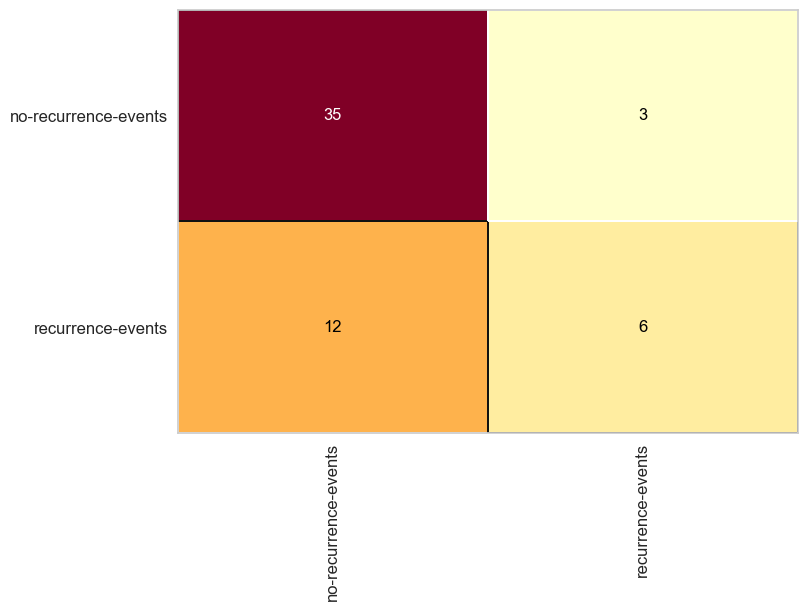

In [15]:
cm = ConfusionMatrix(arvore)
cm.score(x_test, y_test)

In [12]:
print(classification_report(y_test, previsoes,zero_division=0))

                      precision    recall  f1-score   support

no-recurrence-events       0.71      0.63      0.67        38
   recurrence-events       0.36      0.44      0.40        18

            accuracy                           0.57        56
           macro avg       0.53      0.54      0.53        56
        weighted avg       0.60      0.57      0.58        56

